In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
print("hello")

# Load .pts files
def load_pts_file(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
        points = []
        for line in lines[3:-1]:  # skip header lines
            x, y = line.strip().split()
            points.append((float(x), float(y)))
        return np.array(points)

# Load data from images and .pts files
def load_data(images_folder, pts_folder):
    image_data = []
    keypoints = []
    for pts_file in os.listdir(pts_folder):
        if pts_file.endswith('.pts'):
            base_name = os.path.splitext(pts_file)[0]
            image_path = os.path.join(images_folder, base_name + '.jpg')
            pts_path = os.path.join(pts_folder, pts_file)

            if os.path.exists(image_path):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                # image = cv2.resize(image, (224, 224))
                image_data.append(image / 255.0)  # normalize image
                points = load_pts_file(pts_path)

                # Normalize keypoints
                points[:, 0] /= image.shape[1]  # normalize x
                points[:, 1] /= image.shape[0]  # normalize y
                keypoints.append(points.flatten())  # flatten
    return np.array(image_data), np.array(keypoints)

# Load your data
images_folder = "/content/drive/MyDrive/asm_data/frontalimages_spatiallynormalized"
pts_folder = "/content/drive/MyDrive/asm_data/frontalshapes_manuallyannotated_46points"

images, keypoints = load_data(images_folder, pts_folder)

ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, keypoints, test_size=0.1, random_state=42)

In [ ]:
def build_model():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(250, 300, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(len(y_train[0]), activation='linear')  # Output layer: 2N keypoints
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])
    return model

model = build_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a checkpoint callback to save the best model
checkpoint_path = "/content/drive/MyDrive/asm_data/checkpoints/checkpoint64plus.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

# Optional: Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,  # Stop training if val_loss doesn't improve for 10 epochs
    mode="min",
    verbose=1
)


In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.3402 - mse: 4.3402   
Epoch 1: val_loss improved from inf to 0.11716, saving model to /content/drive/MyDrive/asm_data/checkpoints/checkpoint64plus.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - loss: 4.1562 - mse: 4.1562 - val_loss: 0.1172 - val_mse: 0.1172
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1275 - mse: 0.1275
Epoch 2: val_loss improved from 0.11716 to 0.02405, saving model to /content/drive/MyDrive/asm_data/checkpoints/checkpoint64plus.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.1232 - mse: 0.1232 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0368 - mse: 0.0368
Epoch 3: val_loss improved from 0.02405 to 0.01033, saving model to /content/drive/MyDrive/asm_data/checkpoints/checkpoint64plus.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step -

In [5]:
def visualize_keypoints(image, keypoints, predicted_keypoints):
    # Convert normalized keypoints back to the resized image dimensions (224x224)
    keypoints = keypoints.reshape(-1, 2) * [250, 300]  # Scale keypoints to resized dimensions
    predicted_keypoints = predicted_keypoints.reshape(-1, 2) * [250, 300]
    print(f"hello this is the keypoints matrix {predicted_keypoints}")

    # Display the image
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='blue', label='Ground Truth', s=10)  # Ground truth
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='red', label='Prediction', s=10)  # Predictions
    plt.legend()
    plt.axis("off")
    plt.show()

Test Loss: 0.3032485246658325, Test MSE: 0.3032485246658325
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
hello this is the keypoints matrix [[-0.77367155  2.79307617]
 [ 2.77876086  1.35066798]
 [ 1.18572963  3.40986243]
 [-1.71292992 -8.58509   ]
 [ 1.2485208  -5.1333636 ]
 [-4.63779643  2.11087838]
 [-2.54171947 -6.11691009]
 [-3.59830935  0.04696618]
 [ 4.08755755 10.27891785]
 [ 0.0499665  -9.31269675]
 [-2.4431434   1.77889313]
 [ 8.29505734  2.24418193]
 [ 2.13022134  7.3670106 ]
 [ 4.65219002  1.37240561]
 [-1.94652204 -4.44050683]
 [ 2.91152904 -5.10371123]
 [-2.87236366  4.81315311]
 [ 0.91173034 -6.46009538]
 [-3.61833582  1.48368054]
 [-1.33695942 -3.77553385]
 [ 0.47854893 -5.16673252]
 [ 5.74339926 -5.45538403]
 [-5.96980006 -2.56631803]
 [ 3.23421601 -1.5283199 ]
 [ 3.94531246  1.98456198]
 [ 1.48879469 -5.73369339]
 [ 5.03122155  6.35584183]
 [-3.54099856  0.45032669]
 [-4.96171368  0.92716583]
 [ 1.74927386  3.35278809]
 [-1.32959126 -9.90305878]
 [-8.77273269  0.64632366]
 [ 1.

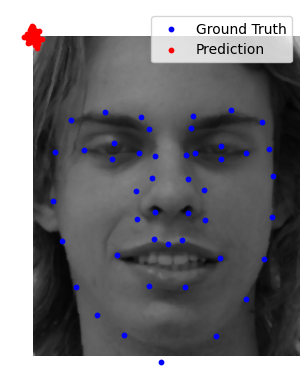

[-0.00309469  0.00931025  0.01111504  0.00450223  0.00474292  0.01136621
 -0.00685172 -0.02861697  0.00499408 -0.01711121 -0.01855119  0.00703626
 -0.01016688 -0.0203897  -0.01439324  0.00015655  0.01635023  0.03426306
  0.00019987 -0.03104232 -0.00977257  0.00592964  0.03318023  0.00748061
  0.00852089  0.0245567   0.01860876  0.00457469 -0.00778609 -0.01480169
  0.01164612 -0.01701237 -0.01148945  0.01604384  0.00364692 -0.02153365
 -0.01447334  0.0049456  -0.00534784 -0.01258511  0.0019142  -0.01722244
  0.0229736  -0.01818461 -0.0238792  -0.00855439  0.01293686 -0.0050944
  0.01578125  0.00661521  0.00595518 -0.01911231  0.02012489  0.02118614
 -0.01416399  0.00150109 -0.01984685  0.00309055  0.0069971   0.01117596
 -0.00531837 -0.0330102  -0.03509093  0.00215441  0.00734875  0.00906053
  0.0079058  -0.00058552  0.00111424  0.0084354  -0.01777374  0.01831735
 -0.01612768  0.00378097  0.00653615 -0.01427028 -0.00299701  0.0124054
 -0.00412084  0.01282171  0.02060268  0.01108047  0.0

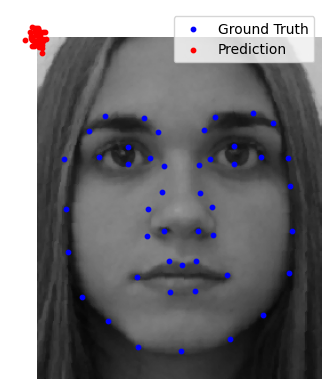

[ 0.00199477  0.00642475  0.00710054  0.01088996  0.00706761  0.01228372
 -0.00946207 -0.02882932 -0.00177436 -0.00825367 -0.01956687  0.003746
 -0.01655362 -0.0319449  -0.01135759  0.00771821  0.0171587   0.04353098
  0.00259752 -0.02761159 -0.01966143  0.00155841  0.03026031  0.00419976
  0.00596905  0.02589943  0.01975849  0.00211512 -0.00340728 -0.01417057
  0.01988423 -0.01757404 -0.00609738  0.00887134  0.00144659 -0.02491751
 -0.01835593  0.00341951  0.00329982 -0.01457625 -0.00207037 -0.01182786
  0.02626455 -0.01714869 -0.02648947 -0.0162138   0.00956267 -0.00969549
  0.01946186  0.00869656  0.00507835 -0.01999064  0.01547578  0.02913496
 -0.01864552  0.0047536  -0.02315463  0.00140553  0.01043009  0.00703617
 -0.00375425 -0.02855362 -0.043131    0.00587476  0.01006896  0.00861373
  0.01242966  0.00694821 -0.00310175  0.00836147 -0.01699674  0.02491602
 -0.02095821 -0.00569721  0.00632483 -0.01717878  0.00065283  0.01968998
 -0.00962121  0.0225309   0.0175813   0.01989539 -0.0

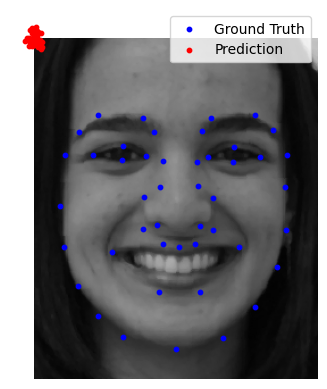

[ 0.0040701   0.01041985  0.01248013  0.00871503  0.00226754  0.01179786
 -0.00731275 -0.03285201  0.00536866 -0.01195117 -0.01763489  0.00258267
 -0.01396131 -0.02559696 -0.00928342  0.00405928  0.02283246  0.03082501
  0.00799198 -0.03498321 -0.01630951  0.00761316  0.02718444  0.00941827
  0.01295838  0.02337451  0.01952954  0.00189787 -0.0049295  -0.01496496
  0.01272221 -0.02077972 -0.00175657  0.01724438  0.00879318 -0.02282395
 -0.0087708   0.00899047 -0.00199987 -0.01260577 -0.00432421 -0.01713603
  0.02503952 -0.01846652 -0.02449516 -0.00342347  0.00994009 -0.00734962
  0.0171279   0.00647271  0.00970218 -0.01618955  0.02602961  0.02359809
 -0.01995535  0.0027335  -0.01732945 -0.00136128  0.00088356  0.00719909
 -0.00729523 -0.02474497 -0.03358638  0.00608304  0.00371504  0.00903982
  0.00216689 -0.00100494 -0.00276185  0.00910015 -0.01896567  0.02042643
 -0.0249432   0.00262583  0.00691599 -0.01841587 -0.00298355  0.00490994
 -0.00633507  0.01997561  0.01412281  0.01623592 -0

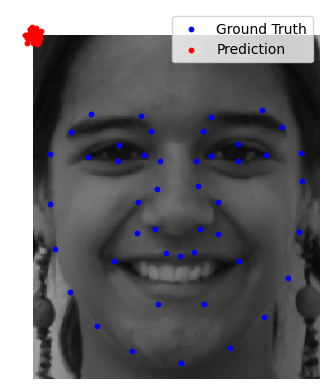

[-0.00668525  0.00216065  0.00923915  0.00276256  0.00772257  0.00903207
 -0.012829   -0.01690959  0.00698871 -0.01164036 -0.01843294  0.00375067
 -0.01431743 -0.02119606 -0.01352729 -0.00271169  0.01135213  0.02281877
  0.00850219 -0.02382861 -0.01050475 -0.00450609  0.02057199 -0.00289366
 -0.0034362   0.01580916  0.01922986  0.00536771 -0.00404819 -0.01232159
  0.01175853 -0.01650969 -0.00275523  0.01365268 -0.0005945  -0.01073137
 -0.00935067  0.00368933 -0.00286638 -0.01117789 -0.00118598 -0.02237053
  0.02418009 -0.01408892 -0.02555715 -0.00460598  0.01506705  0.00097697
  0.00802262  0.0047952   0.002833   -0.01832002  0.01614918  0.01738553
 -0.02345095  0.00567592 -0.01405801 -0.00141911  0.00875083  0.01420278
 -0.00828201 -0.02700651 -0.03256857 -0.00291323  0.00186723  0.00758415
  0.00682039 -0.00269662  0.00418136 -0.00141748 -0.02389346  0.01839026
 -0.01552572  0.00499317  0.00536407 -0.00883043 -0.00362447  0.00599803
  0.00236779  0.01090643  0.01482527  0.01644592  0

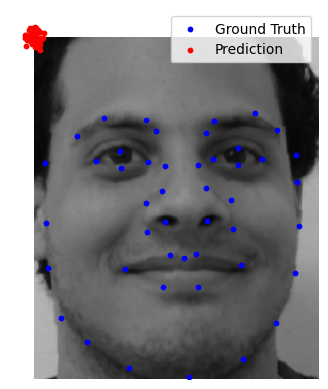

[-5.4069757e-03  8.1730839e-03  7.4983519e-03  1.1763336e-02
  1.6057655e-02  1.0873465e-02 -2.0137768e-02 -2.3581721e-02
  4.4627804e-03 -1.2839728e-02 -2.7229151e-02  4.2115459e-03
 -1.5907871e-02 -2.9933752e-02 -1.5087547e-02 -2.0861980e-03
  2.1098780e-02  3.3607803e-02  1.1491558e-02 -2.4141788e-02
 -1.1452017e-02 -2.9712496e-03  2.9663827e-02  4.6986435e-04
  1.4844323e-03  2.5990395e-02  2.4305694e-02  4.8895357e-03
 -1.1973692e-02 -1.2677137e-02  2.0082857e-02 -1.6646210e-02
 -6.9848918e-03  1.2014374e-02  4.4474662e-03 -2.8681163e-02
 -1.3463428e-02  7.8672357e-03  3.3493834e-03 -1.6381346e-02
 -3.8914827e-03 -1.9790968e-02  3.4106575e-02 -1.5571067e-02
 -3.1276826e-02 -9.0147834e-03  1.5013748e-02  4.7129993e-03
  1.1870906e-02  6.2601459e-03  1.1371109e-03 -3.2590557e-02
  2.0691600e-02  2.1124464e-02 -2.9059131e-02 -2.8286302e-03
 -1.5655454e-02  1.3868762e-03  6.2842621e-03  2.4957189e-02
 -6.1606821e-03 -3.0390732e-02 -3.3824421e-02 -5.0699641e-04
  6.5246159e-03  8.38655

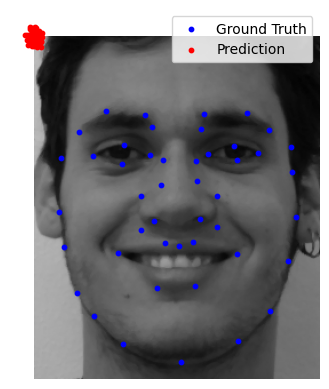

[-0.00858136  0.00838901  0.01319311  0.00960912  0.01311202  0.00706424
 -0.01599275 -0.0227359   0.00509424 -0.00915464 -0.02506296  0.00905977
 -0.01514832 -0.02995936 -0.01427554 -0.01006215  0.00896344  0.02727466
  0.00591547 -0.02608427 -0.01607793 -0.00355397  0.02641484  0.00025153
 -0.00789489  0.02586766  0.02043205  0.01206428 -0.00624802 -0.02160916
  0.01494989 -0.01951343 -0.0024554   0.01656468  0.00482631 -0.01147416
 -0.01094491  0.00182543 -0.00515868 -0.01580995 -0.00297134 -0.027181
  0.02660049 -0.01219574 -0.02591088 -0.00788681  0.01028205 -0.00581697
  0.00269689  0.0050535   0.00253574 -0.02911054  0.02231075  0.01531471
 -0.02753638  0.008084   -0.01616235 -0.00593318  0.00630806  0.01871666
 -0.01109375 -0.02611626 -0.03495118 -0.00573645  0.01120098  0.00999667
  0.00776878 -0.00021145  0.00999933  0.00432485 -0.02354147  0.02248494
 -0.02283622 -0.00083391  0.00697473 -0.01503387 -0.01653771  0.01175643
 -0.00568249  0.01600812  0.02046686  0.02751684  0.0

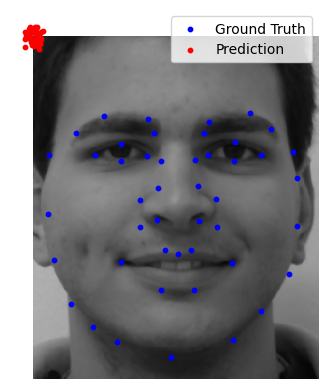

[-6.3536279e-03  7.7977339e-03  1.2184603e-02  1.0603941e-02
  2.1912649e-02  1.6639743e-02 -1.4309919e-02 -2.0149903e-02
  8.1663635e-03 -1.1000580e-02 -3.1496771e-02  5.6887181e-03
 -1.7283037e-02 -2.5681306e-02 -1.5431744e-02 -4.0319078e-03
  1.6790876e-02  3.4540847e-02  9.9393800e-03 -2.9535227e-02
 -1.8784888e-02 -5.0690603e-03  2.2497466e-02 -1.1622533e-04
  3.5010464e-04  2.4138000e-02  2.5596108e-02  5.0595314e-03
 -4.3649040e-03 -1.5670143e-02  2.2701319e-02 -1.5969882e-02
 -5.7107834e-03  1.2846451e-02  5.7303901e-03 -2.5652120e-02
 -1.4203087e-02  5.4255314e-03 -1.7609089e-03 -1.4437566e-02
 -2.6403093e-03 -1.9952858e-02  3.3012614e-02 -1.8198945e-02
 -3.2763373e-02 -1.6060974e-02  1.2769766e-02 -3.7817890e-03
  5.7146586e-03  1.0580402e-02  2.2851769e-03 -3.0420126e-02
  1.8849896e-02  2.1841116e-02 -2.8007463e-02  2.6523538e-03
 -1.6260149e-02 -3.1856471e-03  6.5115420e-03  2.1040469e-02
 -1.2821490e-02 -3.0357724e-02 -2.9373124e-02 -4.3036174e-03
  8.3749620e-03  1.00282

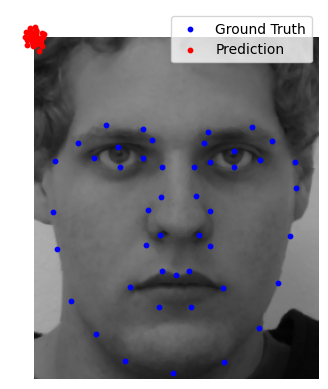

[-9.9602407e-03  1.5485873e-03  1.2657884e-02  2.2947313e-03
  1.8282246e-02  1.0727648e-02 -1.6820332e-02 -2.5313292e-02
  2.5299266e-03 -6.6822805e-03 -2.6568241e-02  5.6329831e-03
 -1.6989842e-02 -2.1004286e-02 -1.9689206e-02 -2.3860056e-03
  1.5297122e-02  3.8559999e-02  4.2899237e-03 -2.4545036e-02
 -1.8511679e-02 -1.3811551e-03  2.8014202e-02 -2.9760753e-03
 -3.9921589e-03  1.8398270e-02  2.1210508e-02  5.0533758e-03
 -8.1256526e-03 -1.5707720e-02  2.6945278e-02 -1.5097625e-02
 -8.7242592e-03  1.0224030e-02  5.7348711e-03 -2.2003762e-02
 -1.2889684e-02  3.4575183e-03  1.4166869e-03 -1.1766018e-02
 -5.0141308e-03 -1.4392487e-02  3.1476993e-02 -1.2276500e-02
 -3.0666143e-02 -1.6362302e-02  1.4484732e-02 -1.5499073e-03
  9.3690157e-03  8.8844262e-03  2.8501009e-03 -3.2293428e-02
  2.7475491e-02  2.3985585e-02 -1.9669071e-02  4.1592508e-03
 -2.1606416e-02 -2.9082876e-05  7.3786629e-03  1.7156102e-02
 -1.4292564e-02 -2.9993579e-02 -3.4648798e-02 -2.8166759e-03
  1.1346968e-02  1.09547

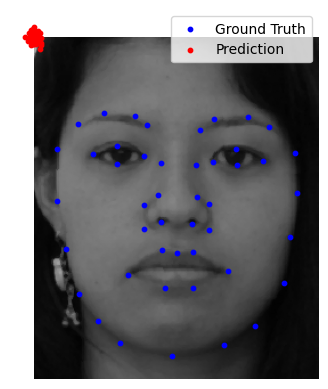

[-0.00287319  0.00302724  0.01792822  0.00142865  0.00652404  0.01168993
 -0.00147233 -0.02325167  0.00452327 -0.01254048 -0.02058572  0.00997923
 -0.01345464 -0.0232869  -0.00907857  0.00568287  0.02017438  0.03336205
 -0.00055761 -0.03158899 -0.01517911  0.00509032  0.02315952  0.00097492
  0.00663185  0.01673841  0.00936712  0.00383367 -0.00604329 -0.01726699
  0.01276498 -0.0204258  -0.00232239  0.01721543  0.00073929 -0.01594223
 -0.00801189  0.00479157  0.00209638 -0.00893403 -0.00084774 -0.01570389
  0.01933012 -0.014522   -0.01962401 -0.01273279  0.01119021 -0.00484045
  0.01505428  0.00533559  0.01087692 -0.01814093  0.02498271  0.02089551
 -0.01445604  0.00843148 -0.01879077  0.00025157  0.00480404  0.00501037
 -0.0038155  -0.02551187 -0.03392567 -0.00245208  0.00716237  0.00688604
  0.01031948  0.00297168  0.00259929  0.00302913 -0.01135351  0.02210919
 -0.01837672  0.00205308  0.00636704 -0.0182066  -0.00351092  0.00831699
 -0.0060793   0.01732972  0.02333191  0.0157133   0

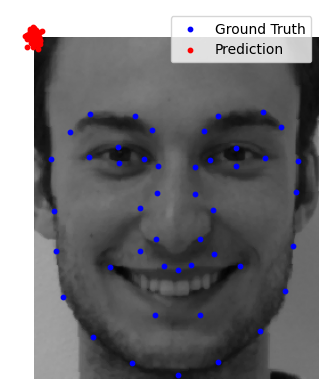

[-0.00570393  0.00671531  0.02191804  0.00646652  0.01495809  0.00806589
 -0.01420112 -0.01930332  0.00413961 -0.01115749 -0.02626257  0.00235358
 -0.01375513 -0.02639109 -0.01392714 -0.00952919  0.01259145  0.03270143
  0.00548389 -0.02217996 -0.01736462 -0.01121516  0.01732806 -0.00317509
 -0.00345897  0.02700643  0.02142077  0.0097556  -0.00556253 -0.01278457
  0.02163202 -0.01611198 -0.00497584  0.00335356 -0.00126916 -0.01834949
 -0.01112401  0.00229778 -0.00141932 -0.00951454 -0.00252287 -0.02152944
  0.02826179 -0.01955239 -0.02486986 -0.00983738  0.01524922 -0.00391162
  0.00045319  0.0046022   0.00115487 -0.02871574  0.01452149  0.0213939
 -0.02197625  0.0012809  -0.01736411  0.00333613  0.00601758  0.01657301
 -0.00571146 -0.03212882 -0.03330355 -0.00475741  0.00854339  0.00563618
  0.01553992 -0.00206551  0.00471425  0.00435841 -0.02673082  0.02770434
 -0.0167795  -0.00241182  0.00987141 -0.00862526 -0.01217582  0.01403762
 -0.00148106  0.01441184  0.01965867  0.0165978   0.

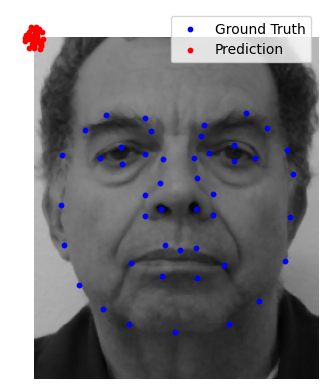

[-0.0033152   0.00599403  0.0152785   0.01000173  0.02434526  0.02035426
 -0.01249297 -0.03221329  0.00422972 -0.00637146 -0.03108308  0.01009946
 -0.01690046 -0.01903682 -0.01256599  0.00077771  0.02179911  0.03282489
  0.0047583  -0.02632324 -0.02065834 -0.00613855  0.03255858  0.00321773
 -0.00023084  0.02978779  0.01902581  0.00732732 -0.00691915 -0.00513329
  0.01843816 -0.02714418  0.00179203  0.00843906  0.00900143 -0.01683567
 -0.00024439  0.00295588  0.00895207 -0.00918157  0.0018109  -0.00869519
  0.02857664 -0.01630964 -0.02955302 -0.008378    0.00945326 -0.00361638
  0.01355566  0.01270486  0.00655757 -0.03208661  0.0242887   0.02240909
 -0.01557042  0.00390582 -0.02388949  0.00240716  0.0075308   0.00771864
 -0.0117672  -0.02691837 -0.03339672 -0.00104088  0.01262181  0.01004645
  0.0174949   0.01142445  0.00604138  0.00383713 -0.01763558  0.02795152
 -0.02895532 -0.00350309  0.00432157 -0.02044355 -0.00548412  0.01688013
 -0.00897034  0.01623363  0.02396148  0.01505732  0

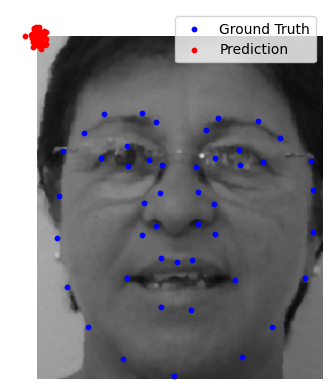

[-0.00890768  0.00347713  0.01986335 -0.00326016  0.01036319  0.0097358
 -0.0125467  -0.02465974  0.00574679 -0.01140843 -0.0169953   0.01282267
 -0.01267296 -0.02889634 -0.0194176  -0.01144104  0.0120658   0.03423053
  0.00266424 -0.02944132 -0.01771244 -0.0007734   0.02690966  0.00592008
  0.00244007  0.02577223  0.01065436  0.011954   -0.01271967 -0.01561124
  0.02049025 -0.01819821 -0.01197788  0.01284952 -0.0015096  -0.01301501
 -0.00809316  0.00155772 -0.0041063  -0.0083011  -0.00232135 -0.02073654
  0.02744519 -0.01451033 -0.02481106 -0.00714184  0.01194769 -0.00207675
  0.00896108  0.00468859  0.00189124 -0.02415566  0.02558854  0.02237855
 -0.02192028  0.00274801 -0.0154889  -0.00361969  0.0113249   0.01888361
 -0.00763769 -0.03049253 -0.04579107 -0.00508194  0.00445632  0.00851289
  0.01654676  0.00010869  0.0067942  -0.00158791 -0.01886651  0.02868283
 -0.01674211  0.00538386  0.00650173 -0.01455464 -0.00683111  0.01149761
 -0.00360219  0.01497328  0.02865662  0.02023753  0.

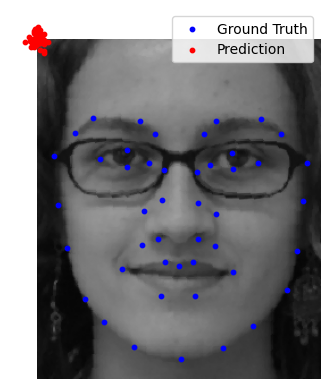

[-0.00290104  0.01322702  0.01322773  0.00645403  0.00376866  0.00828386
 -0.00852463 -0.0313155   0.00613771 -0.0220719  -0.01939769  0.00190075
 -0.01259561 -0.02673125 -0.00618409  0.00469113  0.02114803  0.04000945
  0.00076852 -0.03790761 -0.01893164  0.00962738  0.03694842  0.00687604
  0.00796207  0.02892647  0.02121119  0.00076421 -0.01121609 -0.02118312
  0.01270941 -0.01803863 -0.00764267  0.01703645  0.00660164 -0.0288567
 -0.01576751  0.00763197 -0.00188929 -0.01058844  0.00060821 -0.01556669
  0.02098292 -0.01816085 -0.03051388 -0.00923788  0.01381792 -0.00764285
  0.02407852  0.00659517  0.00944027 -0.02159425  0.02217277  0.03227542
 -0.01979209  0.00257479 -0.02600294  0.00438048  0.00996106  0.01038652
 -0.0070485  -0.0312171  -0.04551561  0.00626879  0.00116847  0.01042715
  0.0057924   0.00064126 -0.00142176  0.0072191  -0.02196715  0.0218841
 -0.02121667 -0.0008482   0.00768311 -0.01864977  0.00083859  0.00729045
 -0.00680961  0.01632205  0.02170629  0.01298768 -0.0

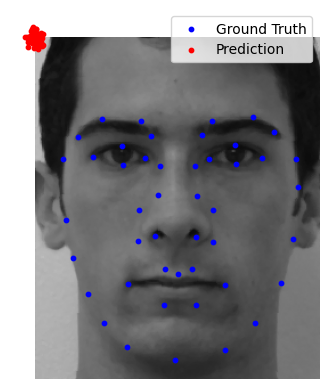

[-0.00992678  0.00457569  0.01858166  0.00252959  0.01223589  0.00603942
 -0.01519755 -0.02073911  0.00048718 -0.00807641 -0.02369551  0.00229944
 -0.01392626 -0.02661122 -0.01251202 -0.01190294  0.00839058  0.0308603
  0.00325732 -0.02797671 -0.01791763 -0.00256     0.02280446 -0.00017115
 -0.00176136  0.02237045  0.01812476  0.00881712 -0.0096402  -0.02102374
  0.01825285 -0.0175912  -0.00375673  0.01369978 -0.00116017 -0.00732204
 -0.01339579  0.00054561 -0.00825783 -0.01199456 -0.00276044 -0.02298437
  0.0271753  -0.01429139 -0.02868194 -0.00557233  0.01222258 -0.00482237
 -0.00074331  0.00403791  0.00192957 -0.0266058   0.02770445  0.01827811
 -0.025909    0.00968144 -0.0223853   0.00236118  0.00467023  0.0190511
 -0.01021364 -0.03382558 -0.03814668 -0.00482947  0.00438103  0.01174624
  0.00761115 -0.00213339  0.00728543  0.00163614 -0.02745067  0.02557809
 -0.02552482  0.00140812  0.00748557 -0.01454664 -0.01271483  0.01303559
 -0.00319953  0.01765342  0.02394219  0.02227244  0.0

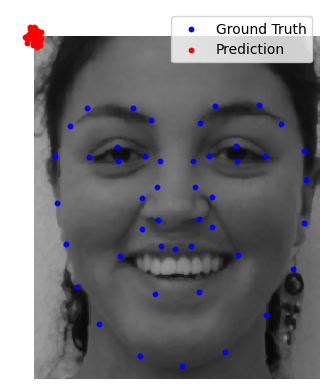

[-5.2192118e-03  5.0159693e-03  8.9371987e-03  2.0918092e-03
  1.5422330e-02  8.5658282e-03 -1.5191086e-02 -2.3202220e-02
  4.9159490e-03 -1.0991297e-02 -2.0755222e-02  3.2574018e-03
 -1.1175880e-02 -2.2225419e-02 -1.5170607e-02 -8.9186616e-03
  9.3996506e-03  2.8188270e-02 -9.7851269e-05 -2.9405423e-02
 -1.8498706e-02 -2.1195882e-03  2.3765005e-02  2.4957613e-03
 -4.8489030e-04  2.1229109e-02  2.1154411e-02  7.4892696e-03
 -2.4212012e-03 -1.2282172e-02  1.4686017e-02 -1.7559025e-02
 -5.3181639e-04  1.8100549e-02  2.7489127e-03 -1.0395552e-02
 -4.4373516e-03  7.5426409e-03 -4.3605221e-03 -1.0146076e-02
 -9.3289725e-03 -1.8995397e-02  2.4236839e-02 -1.4308357e-02
 -2.5896424e-02 -2.4870839e-03  2.0753153e-02  3.7317257e-04
  8.9491773e-03  7.3703821e-03  1.2185720e-03 -2.6682865e-02
  2.0010917e-02  2.4140716e-02 -2.6452648e-02  7.0585897e-03
 -1.7357748e-02  1.5434506e-04  9.2612244e-03  1.6354635e-02
 -1.4604373e-02 -2.8134057e-02 -3.3175711e-02  5.0251605e-04
  8.2573611e-03  1.06107

In [ ]:
# loss, mse = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MSE: {mse}")

# Predict keypoints
predictions = model.predict(X_test)

# Display predictions
for i in range(5, 20):  # Visualize the first 5 test images
    visualize_keypoints(X_test[i], y_test[i], predictions[i])
    print(predictions[i])




In [ ]:
# Save the model
model.save("/content/drive/MyDrive/asm_data/model/facial_keypoints_model_64plus.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
hello this is the keypoints matrix [[108.01152885 164.04322386]
 [142.6435858  163.80695701]
 [ 75.57277381 200.84933639]
 [112.8122732  190.13387561]
 [124.88123775 191.86677933]
 [136.73056662 190.6586051 ]
 [171.01088166 201.18834972]
 [139.17687535 223.25146794]
 [108.50408673 224.56528544]
 [ 50.73391274 104.29131389]
 [ 72.93760777  95.23175061]
 [ 96.57400101 103.82222235]
 [ 74.04948026 108.51565003]
 [150.49551427 103.49602103]
 [174.81102049  94.85092163]
 [197.49854505 103.81120741]
 [174.31534827 110.34091115]
 [ 16.64729603 102.89361477]
 [ 17.31652953 148.30572009]
 [ 23.57955277 186.72074676]
 [ 34.4633311  225.06492734]
 [ 54.03884128 250.68497658]
 [ 80.91190457 272.41383791]
 [123.53090197 281.1883986 ]
 [168.81474853 269.86938715]
 [196.25614583 243.21298599]
 [215.73071182 208.26814771]
 [223.32535684 168.71123314]
 [227.43554413 126.82603598]
 [225.09638965 104.25294042]
 [ 35.68411618  80.99470139]
 [ 54.29853126  66.78376794

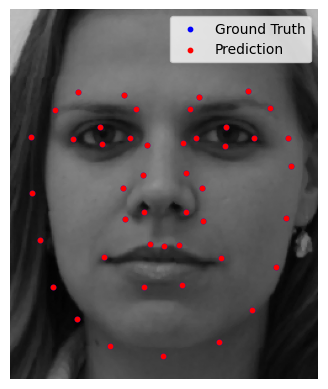

In [6]:
# Load and use the model for inference
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagepath = "/content/drive/MyDrive/asm_data/frontalimages_spatiallynormalized/100a.jpg"

loaded_model = load_model("/content/drive/MyDrive/asm_data/model/facial_keypoints_model_50.h5")
new_image = cv2.imread(imagepath)
new_image_resized = cv2.resize(new_image, (250, 300)) / 255.0
new_image_keypoints = loaded_model.predict(np.expand_dims(new_image_resized, axis=0))
visualize_keypoints(new_image_resized, new_image_keypoints[0], new_image_keypoints[0])


# Data Preprocessing

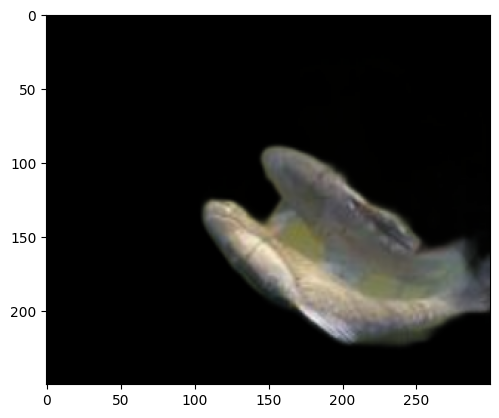

In [ ]:
import imageio.v3
import io
import matplotlib.pyplot as plt
from skimage.transform import resize
from rembg import remove

def take_input(filepath):
    with open(filepath, 'rb') as f:
        input_img = f.read()

    # remove background image
    img_no_bg = remove(input_img)

    # reconvert to NumPy array
    img = imageio.v3.imread(io.BytesIO(img_no_bg), format_hint=".png")
    # img = imageio.v3.imread(filepath)

    if img.ndim == 2:  # grayscale image
        img = np.stack((img,) * 3, axis=-1)
    elif img.shape[-1] == 4:  # alpha
        img = img[..., :3]

    img = resize(img, (250, 300, 3), mode='reflect', anti_aliasing=True).astype('float32')
    return img

image = take_input("./Labs/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG")
plt.imshow(image)

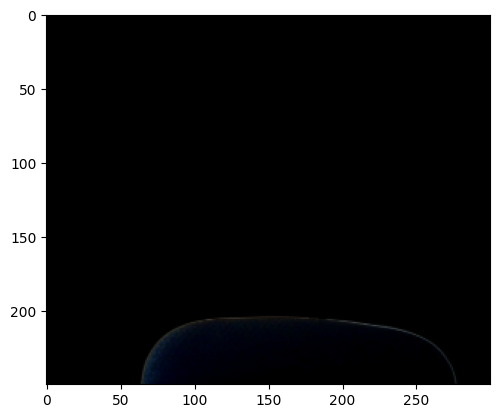

In [ ]:
import cv2

def take_camera_input(output_file='camera_out.jpg'):
    # Open the camera
    camera = cv2.VideoCapture(0)
    if not camera.isOpened():
        print("Error: Unable to access the camera.")
        return

    print("Camera is ready. Press 'q' to quit.")

    captured_frame = None
    while True:
        # Read frame from the camera
        ret, frame = camera.read()
        if not ret:
            print("Error: Unable to read from the camera.")
            break

        # Convert frame to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show(block=False)
        plt.pause(0.001)

        # Prompt user for input
        user_input = input("Press 'c' to capture an image, 'a' to take another frame, or 'q' to quit: ").strip().lower()
        if user_input == 'c':
            captured_frame = frame
            print(f"Image captured and saved to {output_file}")
            break
        elif user_input == 'a':
            continue
        elif user_input == 'q':
            print("Quit without capturing.")
            break

        # NOTE: doesn't work on jupyter notebooks
        # # Check for user input
        # user_input = plt.waitforbuttonpress(timeout=0)
        # if user_input:
        #     # Get the key pressed
        #     key = plt.get_current_fig_manager().canvas.manager.keypress
        #     if key == 'c':
        #         # Capture the current frame
        #         captured_frame = frame
        #         print(f"Image captured and saved to {output_file}")
        #         break
        #     elif key == 'q':
        #         # Quit without capturing
        #         print("Quit without capturing.")
        #         break

    # Save the captured frame if available
    if captured_frame is not None:
        cv2.imwrite(output_file, captured_frame)

    # Release the camera
    camera.release()
    plt.close()

take_camera_input()

In [ ]:
def ilyc_interface():
    '''
    Interface for program.
    Prompts user to input image filepath or use camera option
    Then, applies preprocessing to bring size to (250, 300, 3) and remove background
    '''
    image_mode = input("Select input mode. Press 'c' to use your computer camera or 'f' to enter a filepath")
    if image_mode == 'c':
        take_camera_input()
        img = 'camera_out.jpg'
    elif image_mode == 'f':
        filepath = input("Enter your filepath: ")
        img = take_input(filepath)